In [ ]:
!pip install -U tensorflow
!pip install -U pycocotools

In [ ]:
# 下载验证集的图像和注释文件
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# 解压文件
!unzip val2017.zip
!unzip annotations_trainval2017.zip -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: 

In [ ]:
# 检查解压后的注释文件路径
!ls /content/annotations/

captions_train2017.json  instances_train2017.json  person_keypoints_train2017.json
captions_val2017.json	 instances_val2017.json    person_keypoints_val2017.json


In [ ]:
import os
import tensorflow as tf
from pycocotools.coco import COCO
import numpy as np
import cv2

# 定义路径
val_img_path = '/content/val2017/'
annotation_file = '/content/annotations/instances_val2017.json'

# 加载COCO数据集
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


In [ ]:
def load_image_and_mask(image_id, coco, img_dir):
    image_info = coco.loadImgs(image_id)[0]
    image = cv2.imread(os.path.join(img_dir, image_info['file_name']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    annotation_ids = coco.getAnnIds(imgIds=image_info['id'])
    annotations = coco.loadAnns(annotation_ids)

    mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    for annotation in annotations:
        mask = np.maximum(coco.annToMask(annotation) * annotation['category_id'], mask)
    mask = cv2.resize(mask, (224, 224))

    return image, mask

In [ ]:
def data_generator(coco, img_dir, img_ids, batch_size=16):
    while True:
        for i in range(0, len(img_ids), batch_size):
            batch_img_ids = img_ids[i:i + batch_size]
            images = []
            masks = []
            for img_id in batch_img_ids:
                img, mask = load_image_and_mask(img_id, coco, img_dir)
                images.append(img)
                masks.append(mask)
            yield np.array(images), np.array(masks)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def create_fcn_model(input_shape=(224, 224, 3), num_classes=80):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def create_fcn_model(input_shape=(224, 224, 3), num_classes=80):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # 增加上采样层以逐步恢复空间尺寸
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 14x14 -> 28x28
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 28x28 -> 56x56
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 56x56 -> 112x112
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 112x112 -> 224x224

    # 最终输出层，调整类别数
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
fcn_model = create_fcn_model()
fcn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 获取部分数据的图像 ID
img_ids = coco.getImgIds()
selected_img_ids = img_ids[:200]

# 创建数据生成器
train_gen = data_generator(coco, train_img_path, selected_img_ids, batch_size=16)

# 训练模型
fcn_model.fit(train_gen, steps_per_epoch=len(selected_img_ids) // 16, epochs=2)

NameError: name 'train_img_path' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


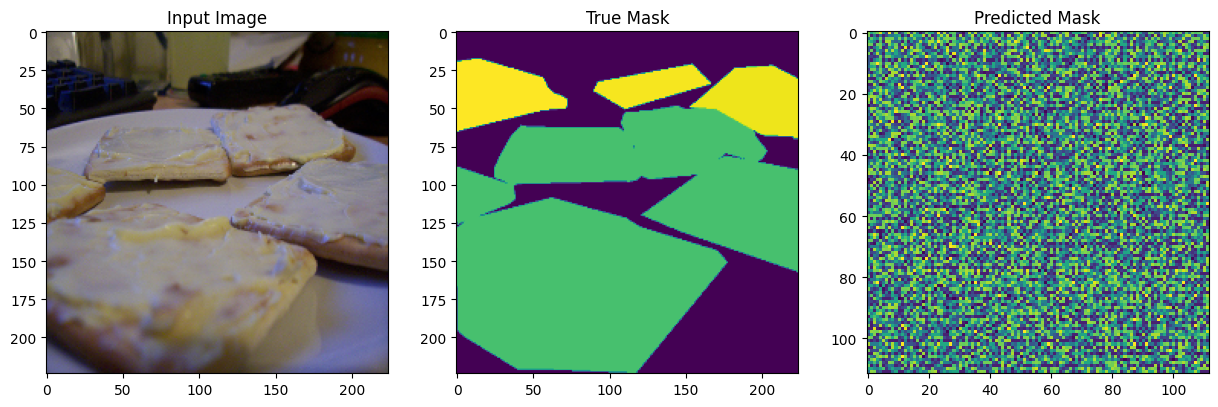

In [ ]:
import matplotlib.pyplot as plt

# 选择验证集的部分图像 ID
val_img_ids = img_ids[200:220]

# 加载并预测一张验证图像
val_img, val_mask = load_image_and_mask(val_img_ids[0], coco, val_img_path)
val_img_input = np.expand_dims(val_img, axis=0)
prediction = fcn_model.predict(val_img_input)

# 由于输出是 one-hot 编码，选择最大值作为预测类别
pred_mask = np.argmax(prediction, axis=-1)[0]

# 显示结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(val_img)
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(val_mask)
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(pred_mask)
plt.title('Predicted Mask')
plt.show()

任务二

In [ ]:
# 1. 安装必要的库
!pip install tensorflow opencv-python-headless
!pip install git+https://github.com/matterport/Mask_RCNN.git

# 2. 克隆 Mask R-CNN 代码库
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN

# 3. 修改 Mask R-CNN 代码库中的导入路径
import os

# 替换函数
def replace_keras_with_tfkeras(file_path):
    with open(file_path, 'r') as file:
        filedata = file.read()
    filedata = filedata.replace('import keras', 'import tensorflow.keras')
    filedata = filedata.replace('from keras', 'from tensorflow.keras')
    with open(file_path, 'w') as file:
        file.write(filedata)

# 遍历文件并替换
rootdir = '/content/Mask_RCNN'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.py'):
            replace_keras_with_tfkeras(os.path.join(subdir, file))

# 4. 下载 COCO 预训练权重
import mrcnn.model as modellib  # 确保正确导入
import mrcnn.config as config
import mrcnn.utils as utils

# 设置路径并下载 COCO 预训练权重
COCO_MODEL_PATH = os.path.join(rootdir, 'mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 5. 配置 Mask R-CNN 模型
from mrcnn.config import Config

class InferenceConfig(Config):
    NAME = "coco"
    NUM_CLASSES = 81  # COCO 数据集有 80 个类 + 1 个背景类
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.6

config = InferenceConfig()

# 6. 加载模型并进行推理
import cv2
import numpy as np
from mrcnn import visualize
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# 加载模型
model = modellib.MaskRCNN(mode="inference", model_dir='/content/Mask_RCNN/logs', config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

# 测试图像的路径（你可以替换为实际的自动驾驶场景图像）
image = cv2.imread('/content/Mask_RCNN/samples/demo.jpg')  # 请替换为你的图像路径
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 执行实例分割
results = model.detect([image], verbose=1)
r = results[0]

# 显示检测和分割结果
plt.figure(figsize=(12, 12))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], r['scores'])
plt.show()